Add `/home/azureuser` to the R library path. You will need to do this to access user installed libraries in every interactive R script.


In [1]:
.libPaths("/home/azureuser")

Check that `/home/azureuser` shows up in the R library path:

In [2]:
.libPaths()

[1] "/home/azureuser"               "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"

Load your required packages:

In [3]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

## NOTES

# Code adapted, modified and optimized from the forecasting example 
# https://microsoft.github.io/forecasting/examples/grocery_sales/
# https://github.com/microsoft/forecasting
# accessed 11/14/2022

# The source of the dataset is from the `bayesm` package and has been 
# saved as csv files and provided in the data/ directory.


library(tidyverse)
library(tsibble)
#library(feasts)
library(fable) # https://fable.tidyverts.org/index.html
library(janitor) # https://github.com/sfirke/janitor


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘tsibble’


The following objects are masked from ‘package:base’:

    intersect, setdiff, union


Loading required package: fabletools


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In order to read a tabular dataset that is registered as a Data asset or stored in a Datastore, you will need to get the complete URI. The URI has the following form: `azureml://subscriptions/<subscription_id>/resourcegroups/<resource_group_name>/workspaces/<workspace_name>/datastores/<datastore_name>/<path/to/file>`

In [4]:
# change this value
file_uri <- "azureml://subscriptions/2fcb5846-b560-4f38-8b32-ed6dedcc0a38/resourcegroups/aml/workspaces/marckvaisman-aml-east2/datastores/workspaceblobstore/paths/LocalUpload/5ab5853aacb93e496303d56211098107/sales-data.csv"

In [5]:
library(reticulate)
use_condaenv("azureml_py38")
pd <- import("pandas")

In [6]:
oj_sales_read <- pd$read_csv(file_uri) |> 
  janitor::clean_names() |>
  as_tibble()

In [7]:
oj_sales_read |> glimpse()

Rows: 106,139
Columns: 19
$ store    <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ brand    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ week     <dbl> 40, 46, 47, 48, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 6…
$ logmove  <dbl> 9.018695, 8.723231, 8.253228, 8.987197, 9.093357, 8.877382, 9…
$ constant <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ price1   <dbl> 0.06046875, 0.06046875, 0.06046875, 0.06046875, 0.06046875, 0…
$ price2   <dbl> 0.06049653, 0.06031250, 0.06031250, 0.06031250, 0.06031250, 0…
$ price3   <dbl> 0.04203125, 0.04515625, 0.04515625, 0.04984375, 0.04359375, 0…
$ price4   <dbl> 0.02953125, 0.04671875, 0.04671875, 0.03734375, 0.03109375, 0…
$ price5   <dbl> 0.04953125, 0.04953125, 0.03734375, 0.04953125, 0.04953125, 0…
$ price6   <dbl> 0.05302083, 0.04781250, 0.05302083, 0.05302083, 0.05302083, 0…
$ price7   <dbl> 0.03890625, 0.04578125, 0.04578125, 0.04578125, 0.04664787, 0…
$ price8   <db

In [8]:
# Constants (were previously defined in a YAML file in the 
# reference example, and ideally can be parametrized

START_DATE <- as.Date("1989-09-14")  

## Data prep

oj_sales <- oj_sales_read |> 
  # complete the missing combinations
  tidyr::complete(store, brand, week) |> 
  # create the actual week based on start date and # of weeks passed
  mutate(yr_wk = tsibble::yearweek(START_DATE + week * 7)) |> 
  select(-week) |> 
  # convert to tsibble
  as_tsibble(index = yr_wk, key = c(store, brand))

# All stores have the same start week (1990 W25) and end week (1992 W41).
# For training, use 100 weeks (1992 W18)

# The model function in fabletools can fit multiple models 
# out of the box

fit <- oj_sales |> 
  filter(yr_wk <= yearweek("1992 W18")) |> 
  model(
    mean = MEAN(logmove),
    naive = NAIVE(logmove),
    drift = RW(logmove ~ drift()),
    arima = ARIMA(logmove ~ pdq() + PDQ(0, 0, 0))
)

# Forecast out 10 weeks
fcast <- forecast(fit, h = 10)

# Evaluate the metrics for each model (one set of metrics
# per modeltype/store/brand)
metrics <- accuracy(fcast, oj_sales)



Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


This dataset includes multiple time series identified by the combination of store and brand. Since the `fable` package can create multiple time series models, we subset all the artifacts for a single combination of store and brand.

In [9]:
sg_data <- oj_sales |> filter(store == 2, brand == 1)
sg_model <- fit |> filter(store == 2, brand == 1)
sg_fcast <- fcast |> filter(store == 2, brand == 1)
sg_metrics <- metrics |> filter(store == 2, brand == 1)

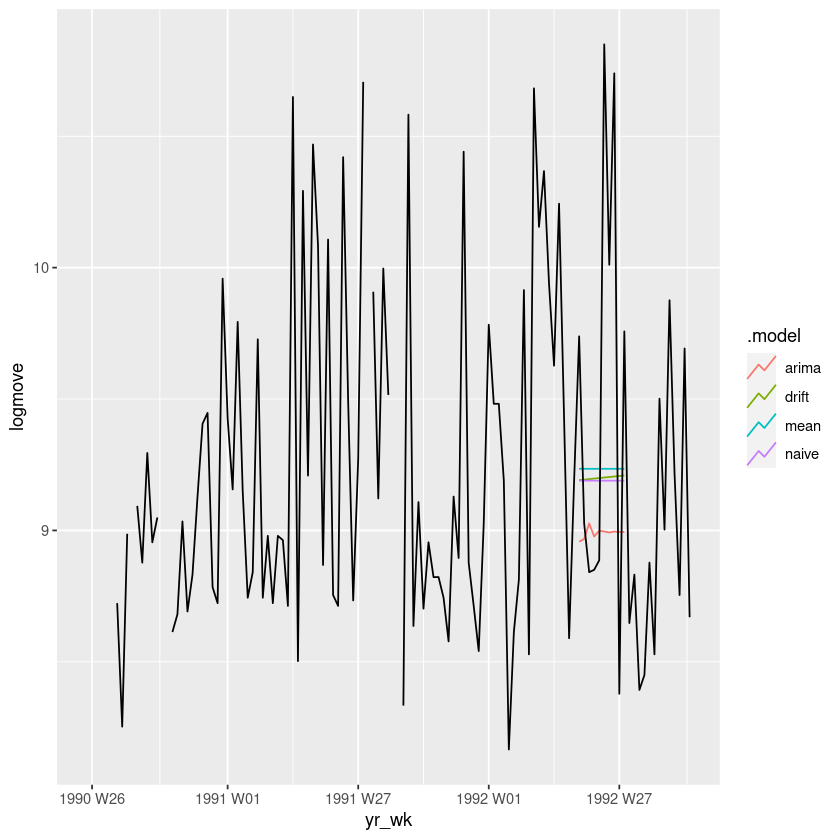

In [10]:
sg_fcast |> 
  autoplot(sg_data, level = NULL)

In [12]:
if (!dir.exists("outputs")){
  dir.create("outputs")
}


In [14]:
forecast_plot <- 
  autoplot(sg_fcast) +
  geom_line(data = sg_data |> 
              filter(yr_wk <= yearweek("1992 W18")),
            aes(x = yr_wk, y = logmove)) 

ggsave(forecast_plot, 
       filename = "./outputs/forecast-plot.png", 
       units = "px",
       dpi = 100,
       width = 800,
       height = 600)


In [15]:
sg_model

store,brand,mean,naive,drift,arima
<dbl>,<dbl>,<model>,<model>,<model>,<model>
2,1,<MEAN>,<NAIVE>,<RW w/ drift>,"<ARIMA(2,1,0)>"


In [20]:
a <- sg_model |>
    pull(arima)

In [24]:
class(a[[1]])

[1] "mdl_ts"

Save objects

ERROR: [1m[33mError[39m in `dont_know()`:[22m
[33m![39m `as_tsibble()` doesn't know how to handle the numeric class yet.
